In [1]:
import torch
import torchvision
from torch import nn
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from einops import rearrange
from torchvision import datasets, transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy

import numpy as np
import matplotlib.pylab as plt

In [2]:
# import D_vae
import Transformer

In [3]:
parser = argparse.ArgumentParser(description='Pre_train MNIST Example')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=20, metavar='N',
#                     help='how many batches to wait before logging training status')
parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--num-class', type=int, default=4,help='num class')

parser.add_argument('--mlp-dim', type=int, default=128, help='_')

parser.add_argument('--num_token',type=int, default=96, help='_')

parser.add_argument('--dropout-rate', type=int, default=0.1, help='_')


args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

In [4]:
#Temperature
T = np.linspace(1,35,35)
#载入数据
data_whole=[]
M_raw_all=[]

for i in [1,2,3,5,7,9]:
    
    with h5py.File('four_phases_data/124_MT_20size_{}T_jiangede.hdf5'.format(i), 'r') as f:
        M_raw=[]
        data=[]

        for i in np.arange(1,len(T)+1):   
            
            dataset=f[str(i)+'.0K']
        
            data.append(dataset[:])

            M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())


    M_raw=np.array(M_raw)
    M_raw_all.append(M_raw)
    data_whole.append(data)
data_whole=np.array(data_whole)
# data_whole=data_whole.reshape(-1,2,10,10)


The_shape=data_whole.shape
print(The_shape)

data_whole=data_whole.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

Tc=19

Phase_label_1=[]

[Phase_label_1.append(0) if i<Tc else Phase_label_1.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_1))

Tc=22

Phase_label_2=[]

[Phase_label_2.append(1) if i<Tc else Phase_label_2.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_2))


Tc=26

Phase_label_3=[]

[Phase_label_3.append(2) if i<Tc else Phase_label_3.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_3))

Phase_label=Phase_label_1+Phase_label_2+Phase_label_3
Phase_label=np.array(Phase_label)
print(Phase_label.shape)


data_whole=torch.tensor((data_whole+1)/2).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

print(data_whole.shape)
print(Phase_label.shape)

#整合数据与标签
data_all=[]
for i in range(data_whole.shape[0]):#
    data_all.append([data_whole[i], Phase_label[i]])

print(len(data_all))


#Temperature
T = np.linspace(1,35,35)
#载入数据
data_whole=[]
M_raw_all_test=[]

for i in [1.5, 4, 8]:
    
    with h5py.File('four_phases_data/124_MT_20size_{}T_jiangede.hdf5'.format(i), 'r') as f:
        M_raw=[]
        data=[]

        for i in np.arange(1,len(T)+1):   
            
            dataset=f[str(i)+'.0K']
        
            data.append(dataset[:])

            M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())


    M_raw=np.array(M_raw)
    M_raw_all_test.append(M_raw)
    data_whole.append(data)
data_whole=np.array(data_whole)

The_shape=data_whole.shape
print(The_shape)

data_whole=data_whole.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

Tc=19
Phase_label_1=[]
[Phase_label_1.append(0) if i<Tc else Phase_label_1.append(3)  for i in range(len(T)) for j in range(The_shape[2])]


Tc=22
Phase_label_2=[]
[Phase_label_2.append(1) if i<Tc else Phase_label_2.append(3)  for i in range(len(T)) for j in range(The_shape[2])]


Tc=26
Phase_label_3=[]
[Phase_label_3.append(2) if i<Tc else Phase_label_3.append(3)  for i in range(len(T)) for j in range(The_shape[2])]

Phase_label=Phase_label_1+Phase_label_2+Phase_label_3
Phase_label=np.array(Phase_label)
print(Phase_label.shape)


data_whole=torch.tensor((data_whole+1)/2).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

print(data_whole.shape)
print(Phase_label.shape)

#整合数据与标签
data_all_test=[]
for i in range(data_whole.shape[0]):#
    data_all_test.append([data_whole[i], Phase_label[i]])

print(len(data_all_test))



(6, 35, 500, 2, 20, 20)
35000
35000
35000
(105000,)
torch.Size([105000, 2, 20, 20])
torch.Size([105000])
105000
(3, 35, 500, 2, 20, 20)
(52500,)
torch.Size([52500, 2, 20, 20])
torch.Size([52500])
52500


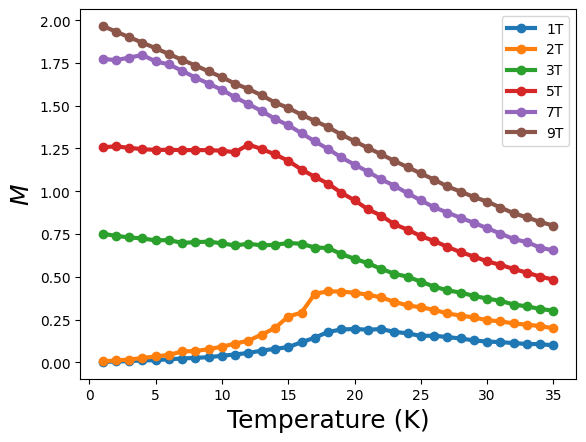

In [5]:
for i, j in zip(range(len(M_raw_all)),[1,2,3,5,7,9]) :

    plt.plot(T,M_raw_all[i],'o-',label='{}T'.format(j),lw=3)


plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)


# plt.text(25,0.05,'Training dataset',fontsize=16)
# plt.text(5,0.30,'Training dataset',fontsize=16)


plt.legend()
plt.show()

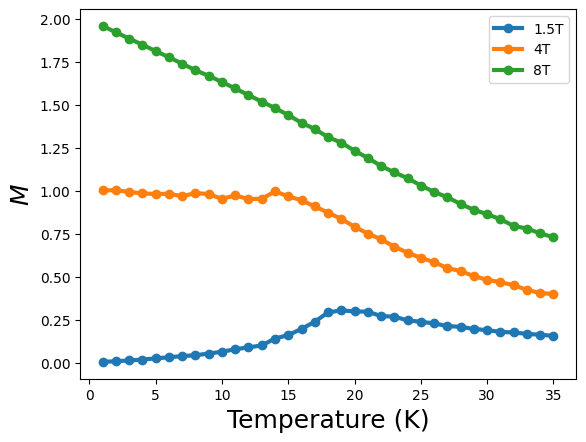

In [6]:
for i, j in zip(range(len(M_raw_all_test)),[1.5, 4, 8]) :

    plt.plot(T,M_raw_all_test[i],'o-',label='{}T'.format(j),lw=3)

plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)


plt.legend()
plt.show()

In [7]:
train_loader = DataLoader(data_all, batch_size = args.batch_size, shuffle=True)
test_loader = DataLoader(data_all_test, batch_size = args.batch_size, shuffle=True )

# shuffled_indices = np.random.permutation(len(data_all))
# train_idx = shuffled_indices[:int(0.8*len(data_all))]
# val_idx = shuffled_indices[int(0.8*len(data_all)):]

# train_loader = DataLoader(data_all, batch_size = args.batch_size, drop_last=False, sampler=SubsetRandomSampler(train_idx))
# test_loader = DataLoader(data_all, batch_size = args.batch_size, drop_last=False, sampler=SubsetRandomSampler(val_idx) )

In [24]:
Model_vit = Transformer.ViT(image_size=args.imgage_size, patch_size=args.imgage_patch, num_classes=args.num_class, channels=args.channels,
            dim=24, depth=2, heads=6, mlp_dim=args.mlp_dim, dropout_rate=args.dropout_rate,token_class=128)#0.4
Model_vit.to(device)
optimizer = torch.optim.Adam(Model_vit.parameters(), lr=2e-3)#,eps=1e-4
train_loss_history, test_loss_history, Accuracy_rate = [], [], []

In [25]:
%%time
for epoch in range(1, args.epochs + 1):#10
    # print('Epoch:', epoch)
    Transformer.fine_tune_train(Model_vit, optimizer, train_loader, train_loss_history,epoch)
    Transformer.fine_tune_evaluate(Model_vit, test_loader, test_loss_history, Accuracy_rate, epoch)

Epoch 1: Average train loss : 0.47302
Epoch 1: Average test loss: 0.49347  Accuracy:37206/52500 (70.87%)

Epoch 2: Average train loss : 0.37872
Epoch 2: Average test loss: 0.47192  Accuracy:39661/52500 (75.54%)

Epoch 3: Average train loss : 0.35116
Epoch 3: Average test loss: 0.41720  Accuracy:40764/52500 (77.65%)

Epoch 4: Average train loss : 0.33582
Epoch 4: Average test loss: 0.45944  Accuracy:39577/52500 (75.38%)

Epoch 5: Average train loss : 0.33026
Epoch 5: Average test loss: 0.42042  Accuracy:41504/52500 (79.06%)

Epoch 10: Average train loss : 0.30538
Epoch 10: Average test loss: 0.42117  Accuracy:41834/52500 (79.68%)

Epoch 20: Average train loss : 0.23006
Epoch 20: Average test loss: 0.27913  Accuracy:46605/52500 (88.77%)

Epoch 30: Average train loss : 0.21003
Epoch 30: Average test loss: 0.24272  Accuracy:47489/52500 (90.46%)

Epoch 40: Average train loss : 0.19575
Epoch 40: Average test loss: 0.22053  Accuracy:47967/52500 (91.37%)

Epoch 50: Average train loss : 0.18539

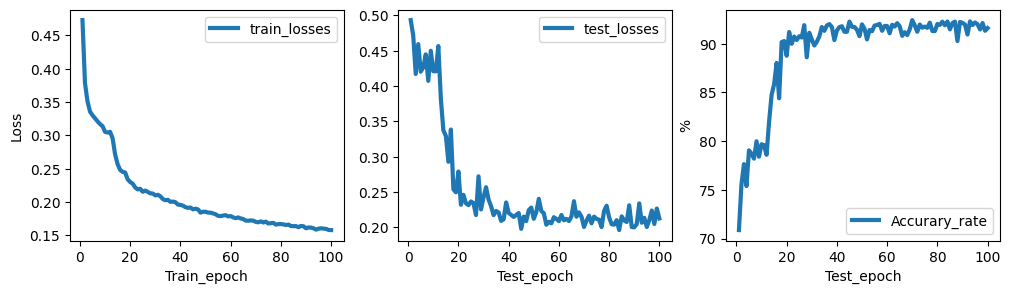

In [26]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()

ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),(Accuracy_rate), linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()

In [16]:
# for i in range(0,20000,500):
#     A_test=data_all_test[i:i+500]
#     Model_vit.eval()
#     all=0
#     with torch.no_grad():
#         for img ,label in A_test:
#             img=img.cuda()
#             img=img.view(-1,2,20,20)
#             A=nn.Softmax(dim=-1)(Model_vit(img,mask=False,classification=True)).argmax(dim=-1)
#             all+=A
#             # print(A)
#         print('{} K The number of PM by model is {}'.format((int(i/500+1)), all.cpu().numpy()))